# Florida_Airbnb Modeling

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
import openpyxl
import sklearn
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

df = pd.read_csv("2000517_final.csv")

## Data cleaning

In [4]:
#Airbnb Host ID는 호스트가 별도로 본인인증(여권 or 소셜 인증)을 통해 게스트와 호스트 간의 신뢰확보를 위한 하나의 도구로 사용
#Host ID 인증이 안되면 게스트 입장에서는 신원이 불분명한 호스트로 인식할 수 있어서 예약률이 떨어질 가능성이 있음
df['Created Date'] = pd.to_datetime(df['Created Date'],format='%Y-%m-%d')
base_datetime = pd.to_datetime('2020-05-17')
df['Created Date'] = (df['Created Date'] - base_datetime).dt.total_seconds()
df['Last Scraped Date'] = pd.to_datetime(df['Last Scraped Date'],format='%Y-%m-%d')
base_datetime = pd.to_datetime('2020-05-17')
df['Last Scraped Date'] = (df['Last Scraped Date'] - base_datetime).dt.total_seconds()
df['Occupancy Rate LTM'] = round(df['Occupancy Rate LTM'],2)
df = df.rename(columns={"Property ID":"propertyid","Property Type":"roomtype","Listing Type":"listype",
                                 "Created Date":"created","Average Daily Rate (USD)":"ADR","Annual Revenue LTM (USD)":"ARL",
                                 "Occupancy Rate LTM":"occupancy","Number of Bookings LTM":"booking","Number of Reviews":"reviewnum",
                                 "Max Guests":"guest","Response Rate":"response","Airbnb Superhost":"superhost","Security Deposit (USD)":"deposit",
                                 "Cleaning Fee (USD)":"cleaningfee","Published Nightly Rate (USD)":"nightfee",
                                 "Published Monthly Rate (USD)":"monthrate","Published Weekly Rate (USD)":"weekrate",
                                 "Minimum Stay":"ministay","Number of Photos":"photonum","Overall Rating":"overall",
                                 "Airbnb Communication Rating":"commrating","Airbnb Accuracy Rating":"accuracyrating",
                                 "Airbnb Cleanliness Rating":"cleanrating","Airbnb Checkin Rating":"checkrating",
                                 "Airbnb Location Rating":"locaterating","Airbnb Value Rating":"valuerating"})

In [5]:
#군집별 특성 파악을 위해 도시, 경도, 위도 변수는 별도로 저장
map = df[['City','Latitude','Longitude']]

In [6]:
df['valuerating'].value_counts()

valuerating
10.0    25758
9.0     13681
8.0      2619
7.0       525
6.0       374
2.0       101
4.0        92
5.0        64
3.0         5
Name: count, dtype: int64

In [4]:
#범주형 변수, 중복 변수, 예약률 예측에 미미한 영향을 미칠 것으로 판단되는 변수들은 제외처리
df.drop(['listype','roomtype','monthrate','weekrate','City','Zipcode','propertyid','created','Latitude','Longitude','Exact Location','Last Scraped Date','Average Daily Rate (Native)','Annual Revenue LTM (Native)','Amenities','Airbnb Property ID','Airbnb Host ID'], axis=1, inplace=True)

In [5]:
#object를 float으로 타입 변환하기
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['superhost'] = encoder.fit_transform(df['superhost'].values)

In [7]:
df.head()

ADR      ARL  occupancy  booking  reviewnum  Bedrooms  Bathrooms  guest  \
0  128.73  19825.0       0.56     46.0      252.0       2.0        1.0    4.0   
1  460.06  35425.0       0.63     22.0       49.0       5.0        4.0   12.0   
2  246.17  15755.0       0.80      2.0        4.0       3.0        2.0    6.0   
3  186.44  14915.0       0.31     22.0       41.0       1.0        1.0    2.0   
4  237.92  24268.0       0.32     27.0       52.0       6.0        4.0   12.0   

   response  superhost  ...  nightfee  ministay  photonum  overall  \
0     100.0          1  ...      80.0       2.0      31.0     97.0   
1     100.0          0  ...     542.0       7.0      29.0     99.0   
2     100.0          0  ...     220.0      20.0      23.0    100.0   
3     100.0          1  ...     135.0       3.0      14.0     98.0   
4     100.0          0  ...     140.0       3.0      44.0     90.0   

   commrating  accuracyrating  cleanrating  checkrating  locaterating  \
0        10.0            10.0         10.0         10.0          10.0   
1        10.0            10.0         10.0         10.0          10.0   
2        10.0            10.0         10.0         10.0          10.0   
3        10.0            10.0         10.0         10.0          10.0   
4         9.0             9.0          9.0          9.0          10.0   

   valuerating  
0         10.0  
1         10.0  
2         10.0  
3         10.0  
4          9.0  

[5 rows x 22 columns]

In [6]:
df.to_csv('final.csv', index=False)

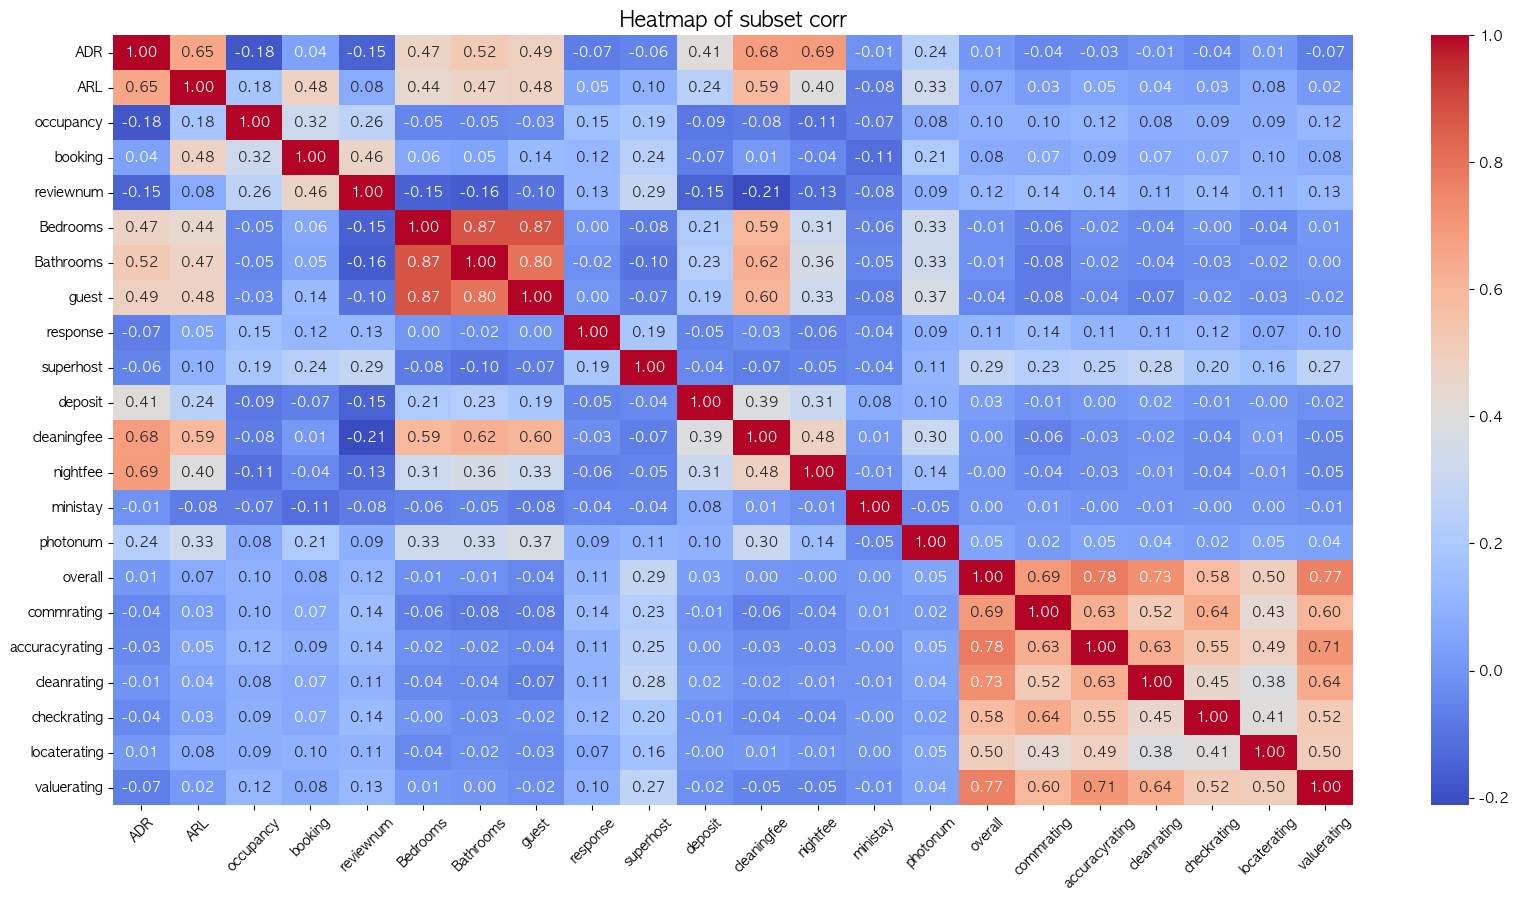

In [42]:
#seaborn을 이용한 heatmap 상관관계 파악
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df.corr()

# 현재 화면의 크기를 가져오기
fig, ax = plt.subplots(figsize=(20, 10))  # 적절한 값을 선택

# 히트맵 그리기
sns.heatmap(data=corr_matrix, cmap='coolwarm', cbar=True, annot=True, fmt='.2f', ax=ax)
plt.title('Heatmap of subset corr', fontsize=15)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 이상치 개수 확인 함수
def count_outliers(data, threshold=1.5):
    outliers_count = []
    
    for column in data.columns:
        # IQR 계산
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # 이상치 경계 계산
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # 이상치 개수 계산
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        outliers_count.append({'Variable': column, 'Outliers_Count': len(outliers)})
    
    return pd.DataFrame(outliers_count)

# 이상치를 평균값으로 대체하는 함수
def replace_outliers_with_mean(data, outliers_df, threshold=1.5):
    for index, row in outliers_df.iterrows():
        variable = row['Variable']
        
        # IQR 계산
        Q1 = data[variable].quantile(0.25)
        Q3 = data[variable].quantile(0.75)
        IQR = Q3 - Q1
        
        # 이상치 경계 계산
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # 이상치를 평균값으로 대체
        data[variable] = np.where((data[variable] < lower_bound) | (data[variable] > upper_bound),
                                  data[variable].mean(), data[variable])
    return data

# 이상치 개수 확인
outliers_count_df = count_outliers(log_data)

# 이상치를 평균값으로 대체
df_replaced = replace_outliers_with_mean(log_data.copy(), outliers_count_df)
df_replaced

In [8]:
# 전체 변수 로그 변환 수행
log_data= np.log1p(df.select_dtypes(include='number'))

In [9]:
log_data

ADR        ARL  occupancy   booking  reviewnum  Bedrooms  \
0      4.865455   9.894749   0.444686  3.850148   5.533389  1.098612   
1      6.133528  10.475201   0.488580  3.135494   3.912023  1.791759   
2      5.510076   9.664977   0.587787  1.098612   1.609438  1.386294   
3      5.233459   9.610190   0.270027  3.135494   3.737670  0.693147   
4      5.476129  10.096955   0.277632  3.332205   3.970292  1.945910   
...         ...        ...        ...       ...        ...       ...   
43214  4.666453   8.464003   0.285179  2.639057   1.945910  0.693147   
43215  4.987776   9.185740   0.336472  2.564949   2.484907  1.098612   
43216  4.586701  10.148627   0.565314  4.369448   3.871201  0.693147   
43217  5.521901  10.262874   0.322083  3.526361   3.218876  0.693147   
43218  5.277451  10.378323   0.392042  3.970292   2.995732  1.098612   

       Bathrooms     guest  response  superhost  ...  nightfee  ministay  \
0       0.693147  1.609438  4.615121   0.693147  ...  4.394449  1.098612   
1       1.609438  2.564949  4.615121   0.000000  ...  6.297109  2.079442   
2       1.098612  1.945910  4.615121   0.000000  ...  5.398163  3.044522   
3       0.693147  1.098612  4.615121   0.693147  ...  4.912655  1.386294   
4       1.609438  2.564949  4.615121   0.000000  ...  4.948760  1.386294   
...          ...       ...       ...        ...  ...       ...       ...   
43214   0.693147  1.098612  3.258097   0.000000  ...  5.010635  1.098612   
43215   1.098612  2.197225  4.615121   0.000000  ...  4.605170  1.098612   
43216   0.693147  1.791759  4.553877   0.000000  ...  4.454347  1.386294   
43217   0.693147  1.609438  4.615121   0.693147  ...  5.525453  1.386294   
43218   1.098612  1.791759  4.615121   0.693147  ...  5.170484  1.386294   

       photonum   overall  commrating  accuracyrating  cleanrating  \
0      3.465736  4.584967    2.397895        2.397895     2.397895   
1      3.401197  4.605170    2.397895        2.397895     2.397895   
2      3.178054  4.615121    2.397895        2.397895     2.397895   
3      2.708050  4.595120    2.397895        2.397895     2.397895   
4      3.806662  4.510860    2.302585        2.302585     2.302585   
...         ...       ...         ...             ...          ...   
43214  3.663562  4.584967    2.397895        2.397895     2.397895   
43215  3.332205  4.543295    2.302585        2.302585     2.302585   
43216  3.135494  4.510860    2.302585        2.302585     2.302585   
43217  2.890372  4.595120    2.397895        2.397895     2.397895   
43218  3.258097  4.584967    2.397895        2.302585     2.397895   

       checkrating  locaterating  valuerating  
0         2.397895      2.397895     2.397895  
1         2.397895      2.397895     2.397895  
2         2.397895      2.397895     2.397895  
3         2.397895      2.397895     2.397895  
4         2.302585      2.397895     2.302585  
...            ...           ...          ...  
43214     2.397895      2.397895     2.397895  
43215     2.302585      2.397895     2.302585  
43216     2.397895      2.397895     2.302585  
43217     2.397895      2.397895     2.302585  
43218     2.397895      2.302585     2.397895  

[43219 rows x 22 columns]

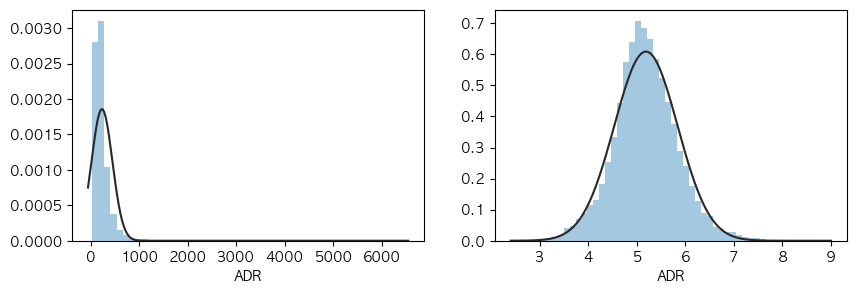

In [44]:
#각 데이터들의 히스토그램을 통한 데이터 분포 파악
import scipy as sp
import scipy.stats

f,ax=plt.subplots(1,2,figsize=(10,3))

#로그변환 전 정규분포
before= df['ADR']
sns.distplot(before, kde=False, rug=False, fit=sp.stats.norm, ax = ax[0])

#로그변환 후 정규분포
after= log_data['ADR']
sns.distplot(after, kde=False, rug=False, fit=sp.stats.norm, ax = ax[1])
plt.show()

## OLS regression

In [45]:
#예측하려는 occupancy에 영향을 미치는 각 변수들의 p-value값, 정확도 확인을 위해 ols 모델 검정
import statsmodels.api as sm

x_data = log_data.drop(['occupancy'], axis=1)
target = df['occupancy']

# 상수항 추가
df_x_ = sm.add_constant(x_data, has_constant = "add")

# 회귀모델 적합
multi_model2 = sm.OLS(target, df_x_)
fitted_multi_model2 = multi_model2.fit()

# 결과 출력
fitted_multi_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              occupancy   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     1696.
Date:                Wed, 13 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:36:07   Log-Likelihood:                 17627.
No. Observations:               43219   AIC:                        -3.521e+04
Df Residuals:                   43197   BIC:                        -3.502e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0478      0.038      1.244      0.213      -0.027       0.123
ADR               -0.2974      0.003    -96.977      0.000      -0.303      -0.291
ARL                0.2146      0.002    137.682      0.000       0.212       0.218
booking           -0.1391      0.002    -85.403      0.000      -0.142      -0.136
reviewnum          0.0176      0.001     21.972      0.000       0.016       0.019
Bedrooms          -0.0241      0.003     -7.145      0.000      -0.031      -0.017
Bathrooms          0.0161      0.004      3.619      0.000       0.007       0.025
guest              0.0252      0.003      7.440      0.000       0.019       0.032
response           0.0026      0.001      1.960      0.050    3.18e-08       0.005
superhost          0.0323      0.003     12.440      0.000       0.027       0.037
deposit           -0.0071      0.001     -5.274      0.000      -0.010      -0.004
cleaningfee       -0.0009      0.002     -0.409      0.683      -0.005       0.003
nightfee           0.0431      0.003     16.905      0.000       0.038       0.048
ministay           0.0019      0.001      2.012      0.044    5.01e-05       0.004
photonum           0.0124      0.002      7.488      0.000       0.009       0.016
overall            0.0246      0.015      1.662      0.096      -0.004       0.054
commrating        -0.0010      0.012     -0.079      0.937      -0.025       0.023
accuracyrating     0.0173      0.014      1.283      0.200      -0.009       0.044
cleanrating       -0.0219      0.011     -2.027      0.043      -0.043      -0.001
checkrating       -0.0353      0.012     -2.848      0.004      -0.060      -0.011
locaterating       0.0150      0.014      1.103      0.270      -0.012       0.042
valuerating        0.0189      0.013      1.419      0.156      -0.007       0.045
==============================================================================
Omnibus:                    10128.398   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35232.852
Skew:                           1.163   Prob(JB):                         0.00
Kurtosis:                       6.762   Cond. No.                         925.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## VIF(Variance Inflation Factor)

In [46]:
#vip(분산팽창요인)을 통한 다중공선성 여부를 확인하는 지표
#지표 기준: 보통 10이 넘어가면 다중공선성이 있다고 판단하지만 다른 방법이랑 같이 확인하는 것이 필요함
#vip가 높은 지표를 한번에 지우지 말고 하나씩 지우면서 확인하는게 중요함
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["vif factor"] = [variance_inflation_factor(
    df.values, i) for i in range(df.shape[1])]
vif["features"] = df.columns
vif = vif.sort_values("vif factor").reset_index(drop=True)
vif

vif factor        features
0     1.139409        ministay
1     1.878816       superhost
2     2.273233         deposit
3     2.483879       reviewnum
4     3.153685        nightfee
5     4.887751        photonum
6     5.705238         booking
7     6.008761             ARL
8     8.411933             ADR
9     8.598906     cleaningfee
10   10.433797       occupancy
11   18.402758       Bathrooms
12   20.358103           guest
13   21.025880        Bedrooms
14   31.968095        response
15  242.163416     cleanrating
16  269.575384    locaterating
17  328.034563     checkrating
18  333.907532     valuerating
19  357.933415      commrating
20  403.905339  accuracyrating
21  577.727827         overall

In [47]:
#원본 데이터의 vip계수가 과도하게 10 이상 넘어가는 과한 변수들은 제외
x_data = x_data.drop(['cleaningfee','Bedrooms','commrating','checkrating'], axis=1)

# SPCA 차원축소를 통한 주성분 파악 및 개수 선정

In [48]:
#sparse PCA를 통한 차원축소
from sklearn.decomposition import SparsePCA

#spca 모델 생성 및 학습
n_components = 10 #원하는 주성분의 수
alpha = 0.5 #spca로 나온 변수의 가중치를 얼마만큼 우리가 쓸꺼냐

sparse_pca = SparsePCA(n_components=n_components, alpha=alpha, random_state=42)
sparse_pca.fit(x_data)

#주성분 추출
spca = sparse_pca.components_

#주성분 가중치 확인
weights = pd.DataFrame(sparse_pca.components_, columns=x_data.columns)
weights

ADR       ARL   booking  reviewnum  Bathrooms     guest  response  \
0 -0.040017 -0.965205 -0.258405  -0.000000  -0.000000 -0.000000 -0.000000   
1  0.605688 -0.000000 -0.000000  -0.302553   0.000223 -0.000000 -0.000000   
2  0.006400  0.000000  0.000000   0.000000   0.011252  0.000000  0.000000   
3 -0.000000 -0.000000 -0.000000  -0.999342   0.022021 -0.000000 -0.000000   
4  0.012848 -0.000000 -0.000000  -0.000000  -0.000000 -0.000000 -0.999917   
5  0.069736  0.000000  0.000000   0.000000   0.015684  0.000000  0.000000   
6  0.002727  0.000000  0.000000   0.000000   0.000000  0.000000  0.000000   
7  0.143485  0.000000  0.000000   0.000000   0.538043  0.830611  0.000000   
8 -0.062193 -0.000000 -0.997766  -0.000000   0.010533 -0.000000 -0.000000   
9  0.016688 -0.000000 -0.000000  -0.000000  -0.000000 -0.000000 -0.000000   

   superhost   deposit  nightfee  ministay  photonum   overall  \
0  -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000   
1  -0.000000 -0.000000  0.735921 -0.000000 -0.000000 -0.000000   
2   0.000000  0.000000  0.000000  0.999875  0.000000  0.006803   
3  -0.000000 -0.000000 -0.023830 -0.000000 -0.000000 -0.008694   
4  -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000   
5   0.000000  0.997436  0.000000  0.000000  0.000000  0.002976   
6   0.000000  0.000000  0.000000  0.000000  0.999996  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8  -0.000000 -0.000000  0.021993 -0.000000 -0.000000 -0.000000   
9  -0.982759 -0.000000 -0.039060 -0.000000 -0.000000 -0.099869   

   accuracyrating  cleanrating  locaterating  valuerating  
0       -0.000000    -0.000000     -0.001977    -0.000000  
1       -0.000366    -0.000000     -0.000000    -0.004962  
2        0.004252     0.002423      0.000766     0.003467  
3       -0.008938    -0.005401     -0.004200    -0.007791  
4       -0.000000    -0.000000     -0.000000    -0.000000  
5        0.000000     0.001889      0.000000     0.000000  
6        0.000000     0.000000      0.000000     0.000000  
7        0.000000    -0.002411      0.000000     0.001166  
8       -0.000000    -0.000000     -0.000000    -0.000000  
9       -0.074284    -0.093886     -0.030958    -0.084355

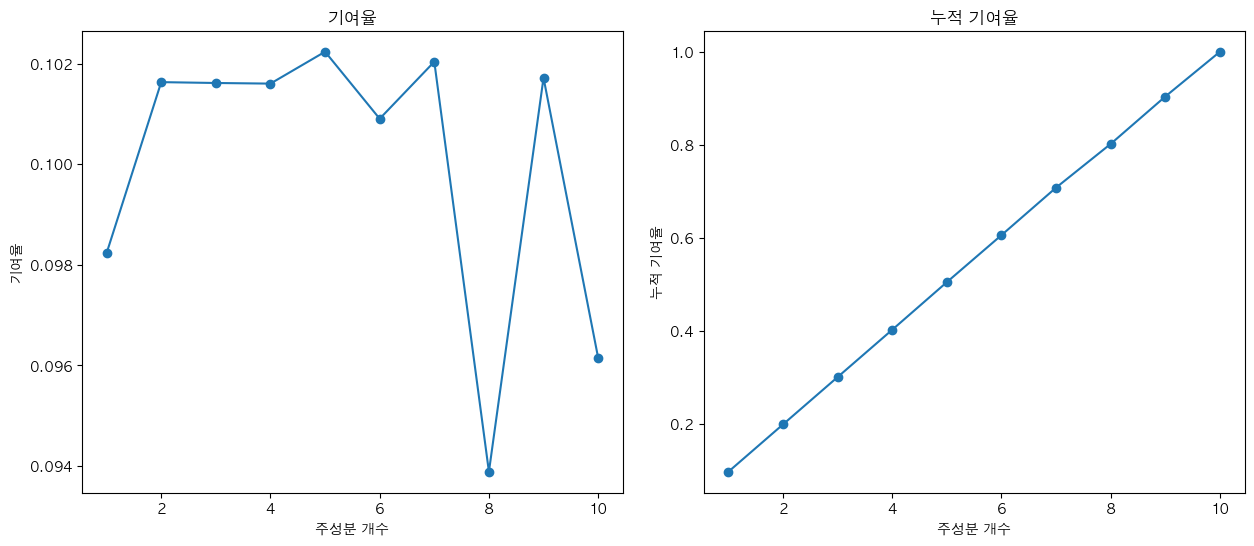

In [49]:
#최적의 주성분 개수를 찾기 위한 Scree plot 그리기
plt.figure(figsize=(15,6))
plt.rcParams["font.family"] = "AppleGothic"

sv = np.var(spca, axis=1) / np.sum(np.var(spca, axis=1))
cumulative = sv.cumsum()

#그래프1: 고윳값
plt.subplot(1,2,1)
plt.plot(range(1, len(sv)+1), sv, marker='o', linestyle='-')
plt.title('기여율')
plt.xlabel('주성분 개수')
plt.ylabel('기여율')

#그래프2: 누적 기여율
plt.subplot(1,2,2)
plt.plot(range(1, len(sv)+1), cumulative, marker='o', linestyle='-')
plt.title('누적 기여율')
plt.xlabel('주성분 개수')
plt.ylabel('누적 기여율')

plt.subplots_adjust(wspace=0.15) #각 그래프가 겹치지 않도록 subplot 간 간격 조절
plt.show()

In [50]:
cumulative

array([0.09823153, 0.19986138, 0.30147423, 0.40307471, 0.50530899,
       0.60621104, 0.7082466 , 0.80213346, 0.903849  , 1.        ])

## SPCA 주성분 수 별 변수 확인

In [51]:
# 주성분 10까지 각 가중치가 높은 상세 변수 파악
selected_components = 10
selected_weights = spca[:selected_components, :]

# 각 주성분에 대한 가중치 확인
for i in range(selected_components):
    component_weights = selected_weights[i, :]
    sorted_indices = np.argsort(np.abs(component_weights))[::-1]  # 가중치의 절댓값을 기준으로 내림차순 정렬
    top_variables = x_data.columns[sorted_indices][:10]  # 가중치가 큰 상위 10개 변수 선택
    print(f"주성분 {i+1}의 가중치가 큰 상위 변수 10개:")
    print(top_variables)
    print()

주성분 1의 가중치가 큰 상위 변수 10개:
Index(['ARL', 'booking', 'ADR', 'locaterating', 'superhost', 'reviewnum',
       'Bathrooms', 'guest', 'response', 'valuerating'],
      dtype='object')

주성분 2의 가중치가 큰 상위 변수 10개:
Index(['nightfee', 'ADR', 'reviewnum', 'valuerating', 'accuracyrating',
       'Bathrooms', 'overall', 'photonum', 'ministay', 'locaterating'],
      dtype='object')

주성분 3의 가중치가 큰 상위 변수 10개:
Index(['ministay', 'Bathrooms', 'overall', 'ADR', 'accuracyrating',
       'valuerating', 'cleanrating', 'locaterating', 'photonum', 'nightfee'],
      dtype='object')

주성분 4의 가중치가 큰 상위 변수 10개:
Index(['reviewnum', 'nightfee', 'Bathrooms', 'accuracyrating', 'overall',
       'valuerating', 'cleanrating', 'locaterating', 'guest', 'ARL'],
      dtype='object')

주성분 5의 가중치가 큰 상위 변수 10개:
Index(['response', 'ADR', 'superhost', 'ARL', 'booking', 'reviewnum',
       'Bathrooms', 'guest', 'valuerating', 'locaterating'],
      dtype='object')

주성분 6의 가중치가 큰 상위 변수 10개:
Index(['deposit', 'ADR', 'Bathrooms', '

In [52]:
#주성분 개수 10개로 하여 SPCA 진행
n_components = 10
alpha = 0.2

sparsepca = SparsePCA(n_components=n_components, alpha=alpha, random_state=42)
sparsepca.fit(x_data)

spca = pd.DataFrame(data=sparsepca.transform(x_data), columns=[f'spca{i+1}' for i in range(n_components)])
spca

spca1     spca2     spca3     spca4     spca5     spca6     spca7  \
0     -0.630625 -1.949110 -0.422810  1.092152 -0.130665  0.016239  0.215654   
1     -0.576608  0.793897  0.550055  1.772874 -0.134954  0.505041  0.149226   
2      1.347145  1.130965  1.505871 -0.502430 -0.132222  0.517780 -0.069903   
3      0.047164 -0.333355 -0.134507  0.534735 -0.129117 -0.378056 -0.534126   
4     -0.440512 -0.502138 -0.135944  0.624535 -0.130458  0.016568  0.552944   
...         ...       ...       ...       ...       ...       ...       ...   
43214  1.258832  0.419764 -0.421287 -0.776624  1.207823 -0.689454  0.408509   
43215  0.743428 -0.077754 -0.422841 -0.645333 -0.131363 -1.070040  0.083178   
43216 -1.139807 -1.165035 -0.141914 -0.134566 -0.075099 -0.005649 -0.113803   
43217 -0.682788  0.480011 -0.139782  0.661879 -0.133452  0.004640 -0.355409   
43218 -1.054518  0.176086 -0.138150  0.092164 -0.133564  0.508772  0.008177   

          spca8     spca9    spca10  
0     -0.384828 -0.476040 -0.437673  
1      0.812657  0.469913  0.214842  
2      0.086839  1.519658  0.223406  
3     -0.806092 -0.097042 -0.441651  
4      0.904038  0.059379  0.263383  
...         ...       ...       ...  
43214 -0.825436 -0.399844  0.202766  
43215  0.362535  0.077922  0.253665  
43216 -0.245425 -0.702781  0.247832  
43217 -0.422099  0.016405 -0.446949  
43218 -0.041149 -0.245964 -0.447846  

[43219 rows x 10 columns]

## K-Means 클러스터링 실루엣 계수 확인

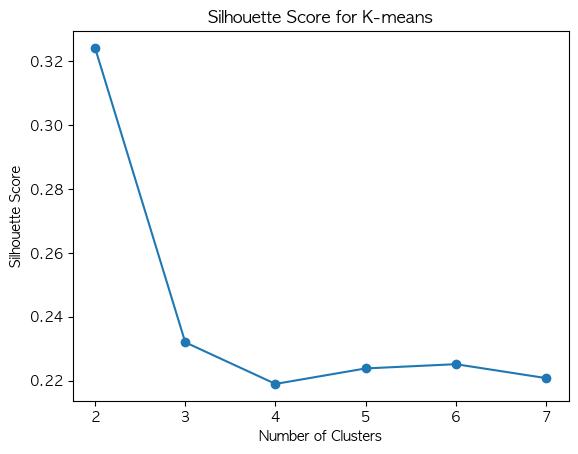

In [20]:
#K-means 실루엣 계수 구하기
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

x = []
y = []

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(spca)
    labels = kmeans.labels_
    
    # Silhouette Score 계산
    silhouette_avg = silhouette_score(spca, labels)
    
    x.append(k)
    y.append(silhouette_avg)

plt.title('Silhouette Score for K-means')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.plot(x, y, marker='o')
plt.show()

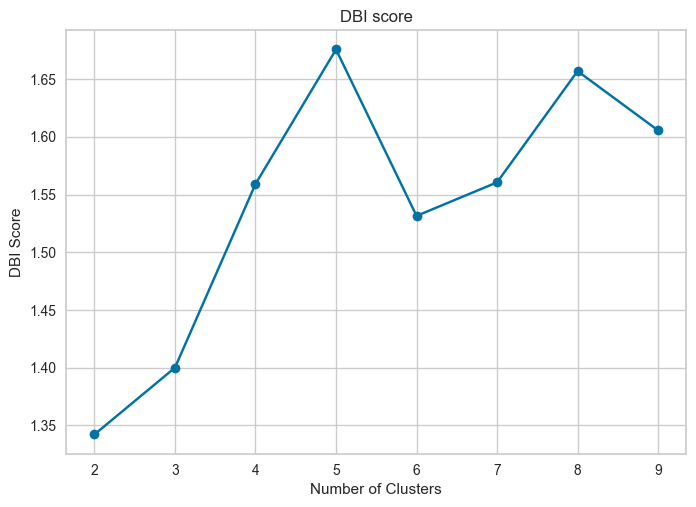

In [56]:
#DBI 산출
#설명: 군집 내 분산과 군집 간 거리의 비율을 사용하여 각 군집이 얼마나 잘 분리되어 있는지를 나타냄, 지수가 작을수록 군집화의 품질이 좋음
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

db_scores = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(spca)
    db_scores.append(davies_bouldin_score(spca, labels))
    
plt.plot(range(2,10), db_scores, marker='o')
plt.title('DBI score')
plt.xlabel('Number of Clusters')
plt.ylabel('DBI Score')
plt.show()

# Clustering

<Axes: xlabel='spca1', ylabel='spca2'>

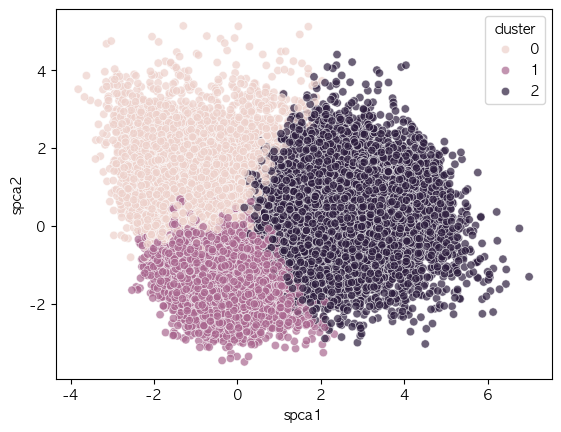

In [53]:
#3개의 군집화로 클러스터
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)

kmeans.fit(spca)
spca['cluster']=kmeans.predict(spca)

sns.scatterplot(x='spca1',y='spca2',hue='cluster',data=spca, alpha=0.7)

In [54]:
spca['cluster'].value_counts()

cluster
1    17594
0    15340
2    10285
Name: count, dtype: int64

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(spca['spca1'], spca['spca2'], c=spca['cluster'], cmap='viridis', s=50, alpha=0.7)
ax.set_xlabel('spca1')
ax.set_ylabel('spca2')
ax.set_zlabel('Cluster')
ax.set_title('3D K-Means Clustering')

# 4번째 차원을 색상으로 나타내기
cbar = plt.colorbar(sc)
cbar.set_label('4th Dimension')

plt.show()

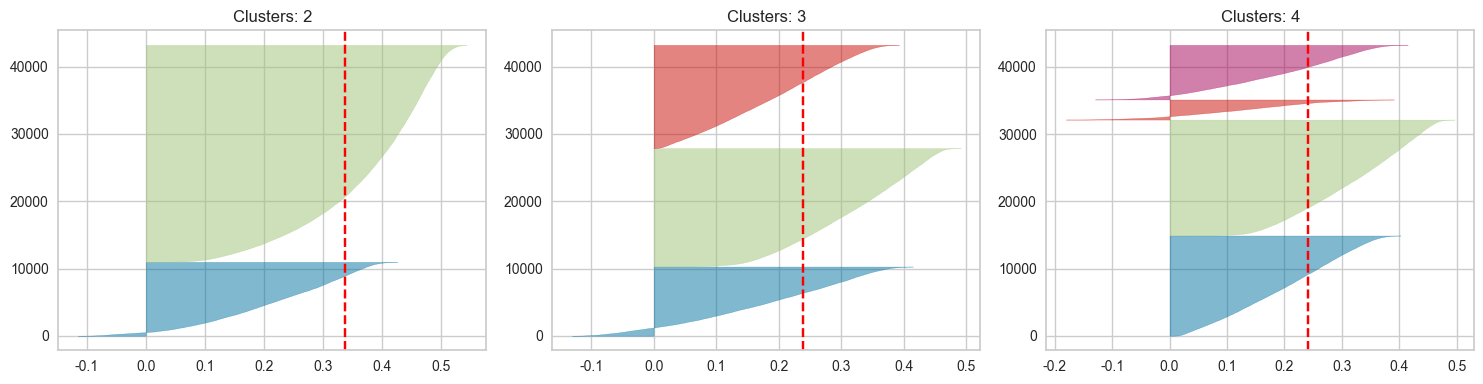

In [55]:
# 클러스터 갯수 범위
from yellowbrick.cluster import SilhouetteVisualizer

cluster_range = [2, 3, 4]

# 그래프의 크기 설정
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 각 클러스터 갯수에 대해 반복
for n_clusters, ax in zip(cluster_range, axes):
    # K-means 모델 생성
    kmeans = KMeans(n_clusters=n_clusters, random_state=111, init='random')
    
    # SilhouetteVisualizer 생성
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax)
    
    # SilhouetteVisualizer 피팅
    visualizer.fit(spca)
    
    # 그래프 제목 설정
    ax.set_title(f'Clusters: {n_clusters}')

plt.tight_layout()
plt.show()

In [18]:
#기존 원본 데이터셋에 cluster 열 추가하기
x_data['cluster'] = spca['cluster']

#spca열에 occupancy data 붙이기
y = pd.DataFrame(target, columns=['occupancy'])
allspca = pd.merge(spca, y, left_index=True, right_index=True)
logdata = pd.merge(x_data, y, left_index=True, right_index=True)

#spca 데이터셋을 클러스터 별로 쪼개기
cluster1 = allspca[allspca['cluster']==0]
cluster2 = allspca[allspca['cluster']==1]
cluster3 = allspca[allspca['cluster']==2]

#로그변환 데이터로 클러스터별로 쪼개기
cluster_1 = logdata[logdata['cluster']==0]
cluster_2 = logdata[logdata['cluster']==1]
cluster_3 = logdata[logdata['cluster']==2]

In [19]:
allspca['occupancy'] = round(allspca['occupancy'],2)
logdata['occupancy'] = round(logdata['occupancy'],2)

In [21]:
logdata.to_csv('logdata.csv', index=False, encoding='utf-8')

# Model Evaluation

## Multi Regression

In [30]:
#로그변환 데이터 다중회귀분석
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# 로그변환 데이터 생성
X_features = logdata.drop(['cluster','occupancy'], axis=1)
y_target = logdata['occupancy']

# 데이터 분할 (학습 데이터와 테스트 데이터)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=42)

# 다중 회귀 모델 학습
model = LinearRegression().fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 성능 지표 계산
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 결과 출력
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared (R2) Score:', r2)

print('===========================================')

# 다중 회귀 모델에 대한 10겹 교차 검증
cv_scores = cross_val_score(model, X_features, y_target, cv=10)  # 10-fold cross-validation
rmse_scores = np.sqrt(-cv_scores)

# 교차 검증 결과 출력
print('Cross-validated R2 scores:', cv_scores)
print('Mean R2 score:', np.mean(cv_scores))

Mean Squared Error: 0.02567632050187897
Root Mean Squared Error: 0.1602383240734843
R-squared (R2) Score: 0.45014780779247576
Cross-validated R2 scores: [0.45793958 0.4659061  0.49120282 0.44840981 0.4324487  0.46284954
 0.42369866 0.4426548  0.4211437  0.43011516]
Mean R2 score: 0.44763688722916567


<Axes: ylabel='None'>

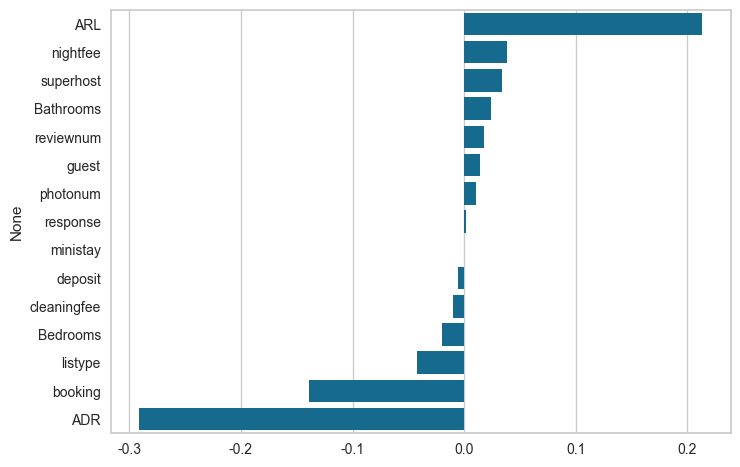

In [31]:
# 회귀 계수 확인: 선형 회귀 모델에서 각 독립변수가 종속변수에 미치는 영향력
# 양수이면 독립변수의 값이 증가할수록 종속변수의 값도 증가함
# 음수이면 독립변수의 값이 증가할수록 종속변수의 값은 감소함

coef = pd.Series(model.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x = coef_sort.values, y=coef_sort.index) 

## Random Forest

In [32]:
#로그 변환 데이터
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

# 로그변환 데이터 생성
X_features = logdata.drop(['cluster','occupancy'], axis=1)
y_target = logdata['occupancy']

# 데이터 분할 (학습 데이터와 테스트 데이터)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=42)

# 랜덤 포레스트 모델 생성
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 교차 검증을 통한 예측
y_pred_cv = cross_val_predict(rf_model, X_features, y_target, cv=10)

# 성능 평가: MSE 및 R-squared
mse_cv = mean_squared_error(y_target, y_pred_cv)
r2_cv = r2_score(y_target, y_pred_cv)

print(f'Mean Squared Error (Cross-Validated): {mse_cv}')
print(f'R-squared (Cross-Validated): {r2_cv}')
print('======================================')

# 모델을 학습 데이터에 맞춥니다.
rf_model.fit(X_train, y_train)

# 테스트 데이터에 대해 예측합니다.
y_pred_test = rf_model.predict(X_test)

# 테스트 데이터에서 성능을 평가합니다.
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f'Mean Squared Error (Test): {mse_test}')
print(f'R-squared (Test): {r2_test}')

Mean Squared Error (Cross-Validated): 0.020896330951896157
R-squared (Cross-Validated): 0.5577793438907724
Mean Squared Error (Test): 0.02047260836726824
R-squared (Test): 0.5615840443289071


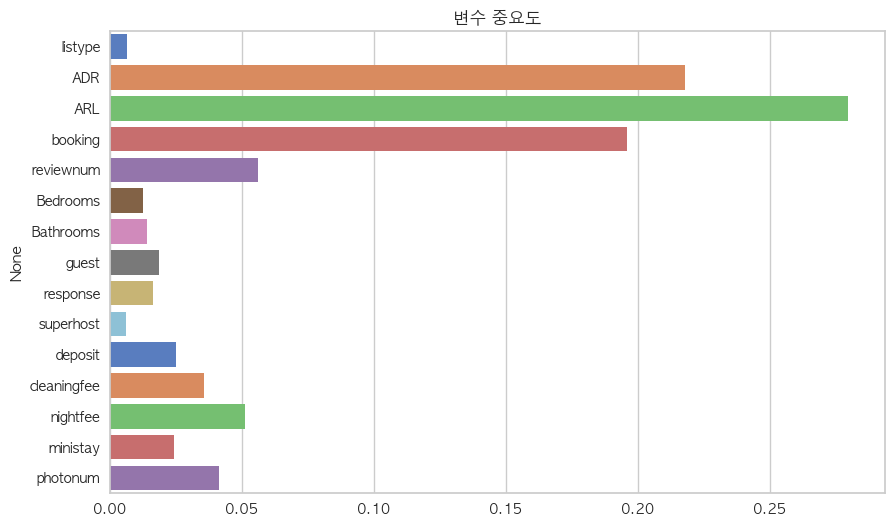

In [33]:
#변수 중요도 파악
plt.rcParams['font.family'] = 'AppleGothic'

feature_importances = rf_model.feature_importances_
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances, y=X_features.columns, palette="muted")
plt.title('변수 중요도')
plt.show()

## SVR(Support Vector Regression)

In [34]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 로그변환 데이터 생성
X_features = logdata.drop(['cluster', 'occupancy'], axis=1)
y_target = logdata['occupancy']

# 데이터 분할 (학습 데이터와 테스트 데이터)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=42)

# SVR 모델 생성
svr_model = SVR(kernel='poly', C=10, epsilon=0.1, degree=3)

# 모델 학습 데이터에 맞추기
svr_model.fit(X_train, y_train)

# test data 예측
y_pred_test = svr_model.predict(X_test)

# 성능 평가: MSE 및 R-squared
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f'Mean Squared Error (Test): {mse}')
print(f'R-squared (Test): {r2}')

Mean Squared Error (Test): 0.020460207839267323
R-squared (Test): 0.561849598636244


# Clustering Model Evaluation

## Multi Regression 

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# MAE, RMSE, RMSLE, R-squared 반환
def evaluate_regr(y, pred):
    # MAE
    mse = mean_squared_error(y, pred)

    # RMSE
    rmse = np.sqrt(mean_squared_error(y, pred))

    # R-squared
    r_squared = r2_score(y, pred)

    print(f'MSE: {mse:.3f}, RMSE: {rmse:.3f}, R-squared: {r_squared:.3f}')

In [37]:
#로그변환한 데이터 학습
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 클러스터의 개수에 따라 반복
for cluster_num in range(3):
    cluster_name = f'cluster{cluster_num}'
    print(f"\n=== {cluster_name} ===")

    # 클러스터 데이터셋 추출
    cluster_data = logdata[logdata['cluster'] == cluster_num]

    # 특성과 타겟 분리
    X_features = cluster_data.drop(['cluster', 'occupancy'], axis=1)
    y_target = cluster_data['occupancy']

    # 학습 데이터와 테스트 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

    # 선형 회귀 모델 학습
    lr_reg = LinearRegression()
    lr_reg.fit(X_train, y_train)

    # test data 예측 및 평가
    print("linear")
    pred_lr = lr_reg.predict(X_test)
    evaluate_regr(y_test, pred_lr)


=== cluster0 ===
linear
MSE: 0.047, RMSE: 0.217, R-squared: 0.466

=== cluster1 ===
linear
MSE: 0.015, RMSE: 0.124, R-squared: 0.498

=== cluster2 ===
linear
MSE: 0.013, RMSE: 0.115, R-squared: 0.509


## Random Forest


=== cluster0 ===
MSE: 0.046, RMSE: 0.215, R-squared: 0.475


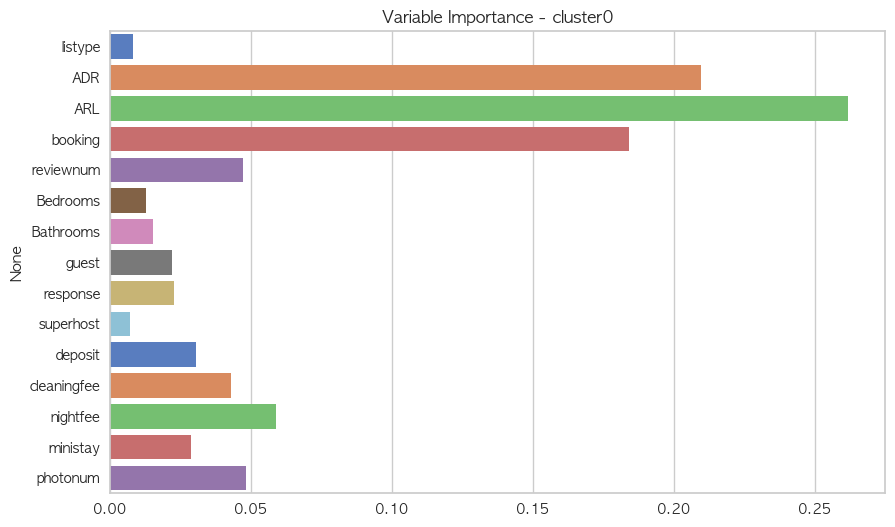


=== cluster1 ===
MSE: 0.013, RMSE: 0.112, R-squared: 0.593


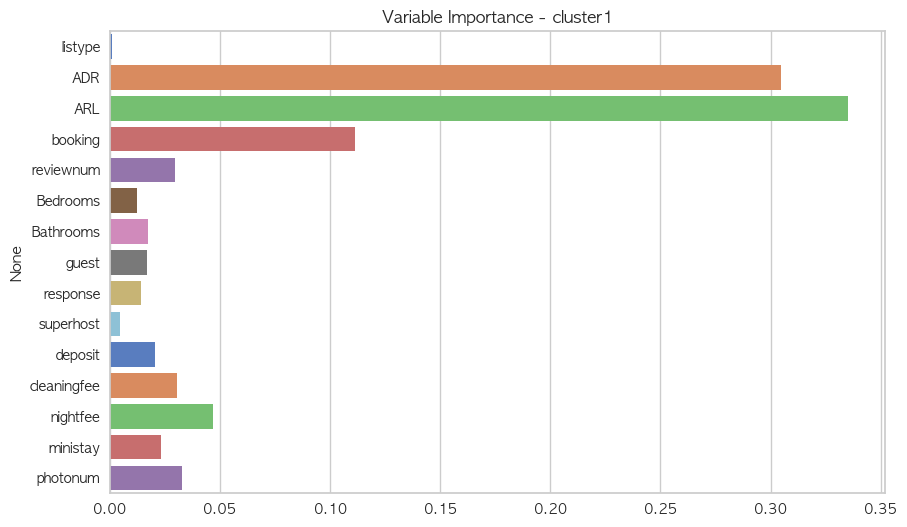


=== cluster2 ===
MSE: 0.012, RMSE: 0.110, R-squared: 0.550


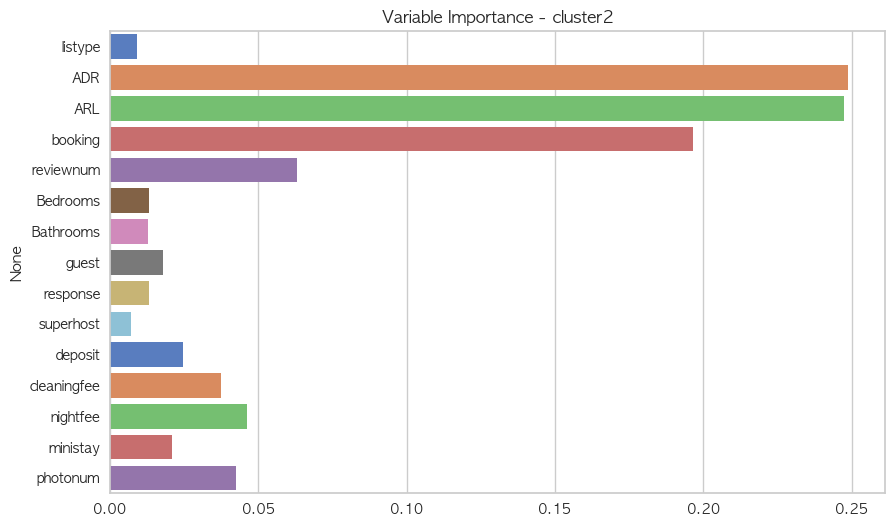

In [38]:
#로그변환 데이터 Random forest
from sklearn.ensemble import RandomForestRegressor

cluster_results = {}

# 클러스터의 개수에 따라 반복
for cluster_num in range(3):
    cluster_name = f'cluster{cluster_num}'
    print(f"\n=== {cluster_name} ===")

    # 클러스터 데이터셋 추출
    cluster_data = logdata[logdata['cluster'] == cluster_num]

    # 특성과 타겟 분리
    X_features = cluster_data.drop(['cluster', 'occupancy'], axis=1)
    y_target = cluster_data['occupancy']

    # 학습 데이터와 테스트 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

    # Random Forest 회귀 모델 학습
    rf_reg = RandomForestRegressor(max_depth=None, n_estimators=100, random_state=0)
    rf_reg.fit(X_train, y_train)

    # 테스트 데이터 예측 및 평가
    pred = rf_reg.predict(X_test)
    evaluate_regr(y_test, pred)

    #변수 중요도 파악
    feature_importances = rf_reg.feature_importances_
    plt.figure(figsize=(10,6))
    sns.barplot(x=feature_importances, y=X_features.columns, palette="muted")
    plt.title(f'Variable Importance - {cluster_name}')
    plt.show()

    # 실제값과 예측값 데이터프레임으로 만들어 딕셔너리에 저장
    result_df = pd.DataFrame({'real_occu':y_test, 'pred_occu':pred})
    result_df['diff'] = np.abs(result_df['real_occu']-result_df['pred_occu'])
    cluster_results[cluster_name] = result_df

In [59]:
# 군집별로 결과 출력
for cluster_name, result_df in cluster_results.items():
    print(f"\n=== {cluster_name} ===")
    result_df[['real_occu', 'pred_occu', 'diff']] = result_df[['real_occu', 'pred_occu', 'diff']].round(2)
    print(result_df[['real_occu', 'pred_occu', 'diff']])


=== cluster0 ===
       real_occu  pred_occu  diff
35855       0.24       0.34  0.10
39077       0.64       0.63  0.01
28090       0.31       0.60  0.29
41216       0.69       0.58  0.11
33158       0.33       0.34  0.01
...          ...        ...   ...
23469       0.18       0.29  0.11
37743       0.48       0.44  0.04
13430       0.56       0.48  0.08
29809       1.00       0.37  0.63
43080       0.80       0.51  0.29

[3338 rows x 3 columns]

=== cluster1 ===
       real_occu  pred_occu  diff
30969       0.51       0.56  0.05
12659       0.63       0.68  0.05
40422       0.57       0.67  0.10
8269        0.63       0.54  0.09
1941        0.64       0.71  0.07
...          ...        ...   ...
31499       0.60       0.66  0.06
40411       0.63       0.55  0.08
22729       0.32       0.43  0.11
2045        0.42       0.51  0.09
35603       0.28       0.34  0.06

[4680 rows x 3 columns]

=== cluster2 ===
       real_occu  pred_occu  diff
24093       0.25       0.36  0.11
25688       


=== cluster0 ===


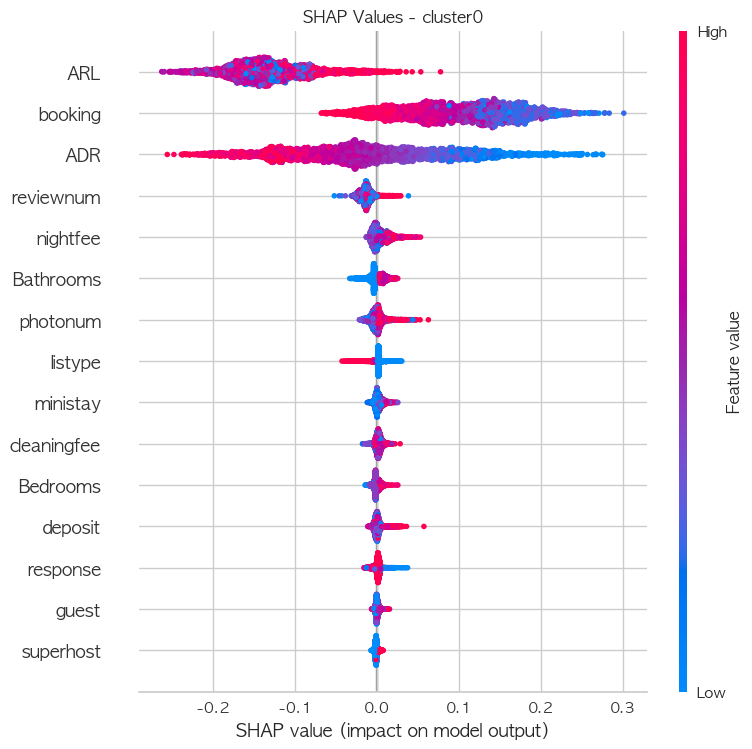


=== cluster1 ===


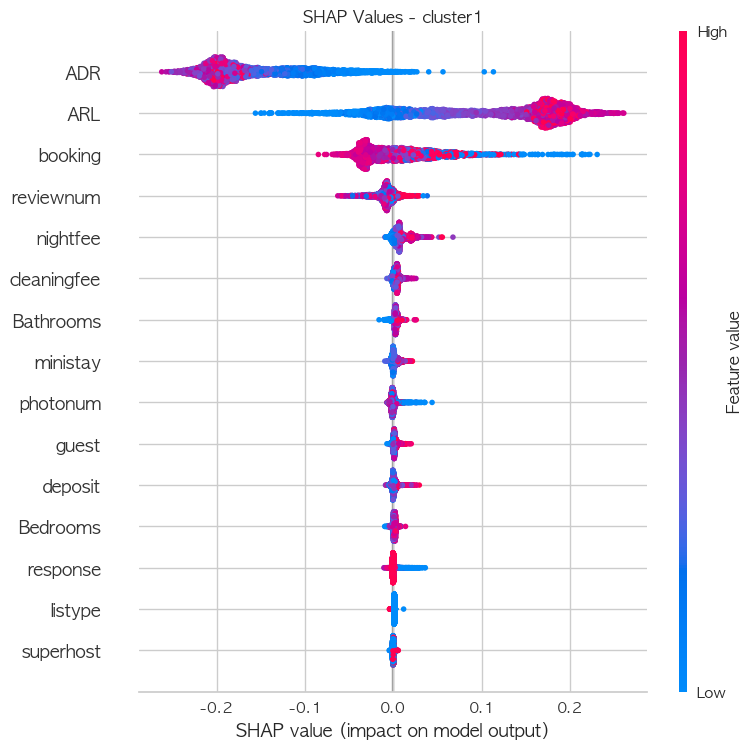


=== cluster2 ===


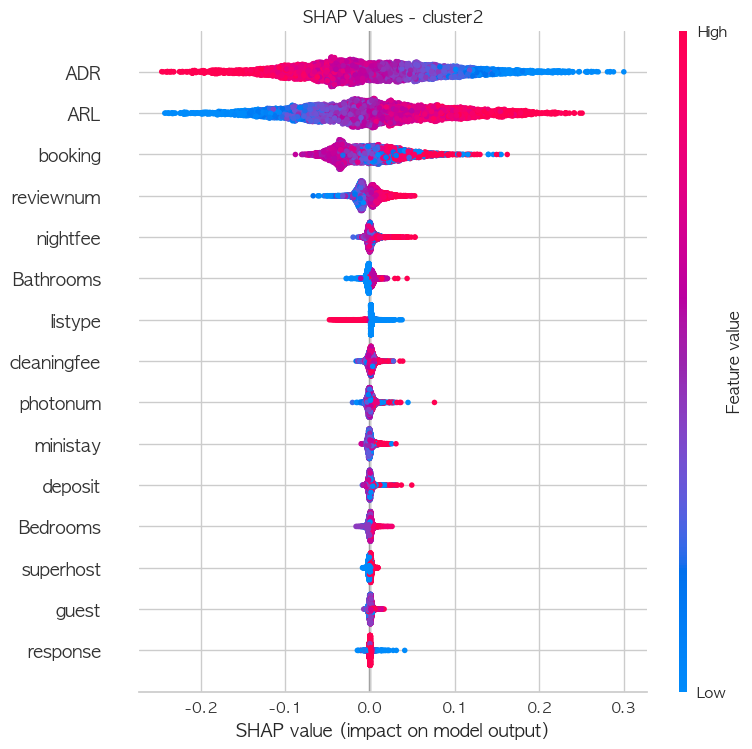

In [61]:
import shap

# Function to evaluate regression performance
def evaluate_regr(y_true, y_pred):
    # Your evaluation code here
    pass

# Assuming 'logdata' is your DataFrame and you have the necessary functions defined

cluster_results = {}

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(rf_reg)

# 클러스터의 개수에 따라 반복
for cluster_num in range(3):
    cluster_name = f'cluster{cluster_num}'
    print(f"\n=== {cluster_name} ===")

    # 클러스터 데이터셋 추출
    cluster_data = logdata[logdata['cluster'] == cluster_num]

    # 특성과 타겟 분리
    X_features = cluster_data.drop(['cluster', 'occupancy'], axis=1)
    y_target = cluster_data['occupancy']

    # 학습 데이터와 테스트 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

    # Random Forest 회귀 모델 학습
    rf_reg = RandomForestRegressor(max_depth=None, n_estimators=100, random_state=0)
    rf_reg.fit(X_train, y_train)

    # 테스트 데이터 예측 및 평가
    pred = rf_reg.predict(X_test)
    evaluate_regr(y_test, pred)

    # Get SHAP values for the test set
    shap_values = explainer.shap_values(X_test)

    # Summary plot of SHAP values
    shap.summary_plot(shap_values, X_test, feature_names=X_features.columns, show=False)
    plt.title(f'SHAP Values - {cluster_name}')
    plt.show()

    # Store SHAP values for further analysis if needed
    shap_df = pd.DataFrame(shap_values, columns=X_features.columns)
    cluster_results[cluster_name] = shap_df

In [62]:
# 군집별로 Shap 가중치 출력
for cluster_name, shap_df in cluster_results.items():
    print(f"\n=== {cluster_name} ===")
    
    # Shap 가중치가 높은 특성 순으로 정렬하여 출력
    for idx, row in shap_df.iterrows():
        sorted_features = sorted(row.index, key=lambda col: abs(row[col]), reverse=True)
        print(f"Row {idx} - Top Features: {sorted_features}")


=== cluster0 ===
Row 0 - Top Features: ['ARL', 'ADR', 'listype', 'reviewnum', 'booking', 'nightfee', 'Bathrooms', 'ministay', 'superhost', 'guest', 'Bedrooms', 'photonum', 'deposit', 'response', 'cleaningfee']
Row 1 - Top Features: ['ARL', 'ADR', 'listype', 'booking', 'reviewnum', 'nightfee', 'deposit', 'superhost', 'Bedrooms', 'photonum', 'Bathrooms', 'guest', 'ministay', 'response', 'cleaningfee']
Row 2 - Top Features: ['ARL', 'ADR', 'booking', 'reviewnum', 'listype', 'ministay', 'photonum', 'nightfee', 'deposit', 'response', 'Bathrooms', 'superhost', 'Bedrooms', 'cleaningfee', 'guest']
Row 3 - Top Features: ['ARL', 'reviewnum', 'ADR', 'cleaningfee', 'listype', 'photonum', 'Bathrooms', 'guest', 'ministay', 'deposit', 'booking', 'superhost', 'Bedrooms', 'nightfee', 'response']
Row 4 - Top Features: ['ARL', 'booking', 'ADR', 'Bathrooms', 'cleaningfee', 'ministay', 'photonum', 'reviewnum', 'nightfee', 'deposit', 'Bedrooms', 'listype', 'response', 'superhost', 'guest']
Row 5 - Top Featu

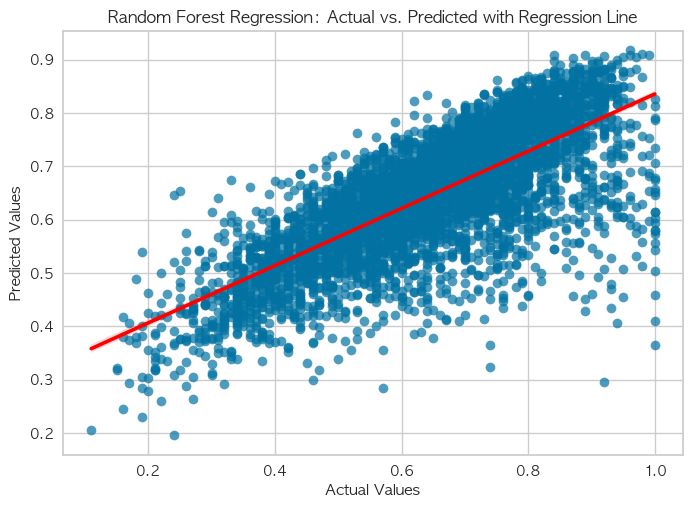

In [41]:
#산점도, 회귀선 시각화

sns.regplot(x=y_test, y=pred, scatter_kws={'alpha':0.7}, line_kws={'color':'red'})
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest Regression: Actual vs. Predicted with Regression Line")
plt.show()

## SVR(Support Vector Regression)

In [42]:
from sklearn.svm import SVR

cluster_results = {}

# 클러스터의 개수에 따라 반복
for cluster_num in range(3):
    cluster_name = f'cluster{cluster_num}'
    print(f"\n=== {cluster_name} ===")

    # 클러스터 데이터셋 추출
    cluster_data = logdata[logdata['cluster'] == cluster_num]

    # 특성과 타겟 분리
    X_features = cluster_data.drop(['cluster', 'occupancy'], axis=1)
    y_target = cluster_data['occupancy']

    # 학습 데이터와 테스트 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

    # SVR 모델 학습
    svr_reg = SVR(kernel='rbf', C=1, epsilon=0.1)
    svr_reg.fit(X_train, y_train)

    # 테스트 데이터 예측 및 평가
    pred = svr_reg.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

    # 실제값과 예측값 데이터프레임으로 만들어 딕셔너리에 저장
    result_df = pd.DataFrame({'real_occu': y_test, 'pred_occu': pred})
    result_df['diff'] = np.abs(result_df['real_occu'] - result_df['pred_occu'])
    cluster_results[cluster_name] = result_df


=== cluster0 ===
Mean Squared Error: 0.04588271425713286
R-squared: 0.47780894413958663

=== cluster1 ===
Mean Squared Error: 0.012702500875390354
R-squared: 0.5875430905803014

=== cluster2 ===
Mean Squared Error: 0.011945933491433592
R-squared: 0.5588340347452484
